# KIT data curation

- **KIT** **(Proto-oncogene c-KIT)** receptor plays a crucial role in regulating cell growth, differentiation, and survival. It's particularly important in the development of blood cells, melanocytes (the cells that produce melanin, the pigment responsible for skin, hair, and eye color), and certain cells in the gut.
    
    Mutations in the KIT gene can lead to uncontrolled cell growth and contribute to the development of certain types of cancer, including gastrointestinal stromal tumors (GISTs) and some types of leukemia.
    
    KIT proto-oncogene, receptor tyrosine kinase, is a transmembrane receptor tyrosine kinase (PMID: 32214210) that binds the stem cell factor (SCF) ligand to activate PI3K, JAK/STAT, and MAPK pathways to promote cell survival and proliferation (PMID: 23181448, PMID: 29704617). Activating Kit mutations are driver mutations in a variety of cancers, particularly in gastrointestinal stromal tumors (PMID: 23127174, PMID: 29704617, PMID: 32091431), acute myeloid leukemia (PMID: 32008291), melanomas (PMID: 30707374, PMID: 32608199), and seminomas (PMID: 29704617).
    
    - **KIT wild type**:  
    In certain cancers, KIT signaling can be activated by other receptors or mutations upstream in the signaling pathway. Targeting these upstream factors can indirectly impact KIT signaling and downstream effects. An example of this is seen in some cases of acute myeloid leukemia (AML) where KIT is expressed without mutations, but other upstream mutations can lead to aberrant KIT activation.
    - **KIT selectivity**: This dataset includes KIT wild type and reported mutants `KIT D816V`, `KIT T6701`, `KIT V560G`. KIT D816V lies within the tyrosine kinase domain 2 of the Kit protein (PMID: 19865100). D816V results in constitutive phosphorylation of Kit, activation of Stat5 signaling (PMID: 19865100, PMID: 18390729), induces mastocytosis and tumor formation in mice (PMID: 21148330) and confers resistance to Kit inhibitors (PMID: 22301675, PMID: 19164557).

**Published RET datasets**: 
- **PKIS 1**: A set of 364 unique small-molecule ATP-competitive kinase inhibitors that was screened by the set in activity assays with 224 recombinant kinases and 24 G protein-coupled receptors and in cellular assays of cancer cell proliferation and angiogenesis. [ref]

**Description of readout:**
- **Readouts**: `KIT_(D816V_mutant)`, `KIT_(T6701_mutant)`, `KIT_(V560G_mutant)`, `KIT`
- **Bioassay readout**: Percentage of inhnibition.
- **Optimization objective**: Higher the more potent.

<a id="curation"></a>
# KIT data curation

**Data pre-processing**

**Step 1** - Curate the chemistry information
  - Clean the molecules by perform molecule sanitization and fix, standardization molecules, salts/solvents removals.
  - Detect the stereochemistry information in the molecules. Such as undefined stereo centers and information. It's crucial in the case of the activity cliff among the stereoisomers.

<br>

**Step 2** - Curate the measured values
  - Identify the compounds which have multiple measures in the dataset. The identification of the repeated molecules is defined by `datamol.hash_mol` including stereochemistry information.
  - Verify the data resource and remove the dubious data points which are significant different or in different classes in case of categorical data. Compute the average of the rest of the duplicated molecules.
  - Detect potential outliers of the dataset. Verify the data resource and remove the dubious data points.
  - Convert the continuous values based on provided threshold values to classification tasks.
  - Detect activity cliff between the stereoisomers. Those isomers and their bioactivity values can be removed/masked from dataset if the downstream molecule representation is not able to differentiate the stereoisomers.

<br>

**Step 3** - Visual inspection
  - Access molecular diversity and distribution in the chemical space. This can guide the decision on which splitting approach to employ. 
  - Visualize the distribution of bioactivity values. It's useful to exam whether it's meaningful to convert to classification task.
  - Check molecules which contain undisered characters.

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
from polaris import curation
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pathlib
os.chdir(pathlib.Path("__file__").absolute().parents[3])
from utils import *

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

In [2]:
# load data
data = pd.read_parquet(
    "gs://polaris-public/Data/kinases/pkis1_curated_&_splits_2023-08-23.parquet"
)


In [3]:
# Define data column names
data_cols = ['KIT_(T6701_mutant)', 'KIT_(V560G_mutant)', 'KIT',]
mol_col = "smiles"
data = data[[mol_col] + data_cols]

In [4]:
data.describe()[data_cols]

,KIT_(T6701_mutant),KIT_(V560G_mutant),KIT
count,364.000000,364.000000,363.000000
mean,13.042445,12.580275,26.585964
std,23.921061,23.244018,33.743584
min,-3.320000,-3.930000,-26.190000
25%,1.282500,0.325000,3.565000
50%,3.575000,2.950000,8.580000
75%,7.320000,10.262500,45.300000
max,98.130000,97.770000,107.780000


In [5]:
for data_col in data_cols: 
    display(data[data_col].groupby(pd.cut(data[data_col], [0,70,75, 80, 90, 100])).count())

KIT_(T6701_mutant)
(0, 70]      291
(70, 75]       3
(75, 80]       2
(80, 90]      12
(90, 100]      7
Name: KIT_(T6701_mutant), dtype: int64

KIT_(V560G_mutant)
(0, 70]      261
(70, 75]       4
(75, 80]       3
(80, 90]      11
(90, 100]      6
Name: KIT_(V560G_mutant), dtype: int64

KIT
(0, 70]      275
(70, 75]       2
(75, 80]       5
(80, 90]      22
(90, 100]     31
Name: KIT, dtype: int64

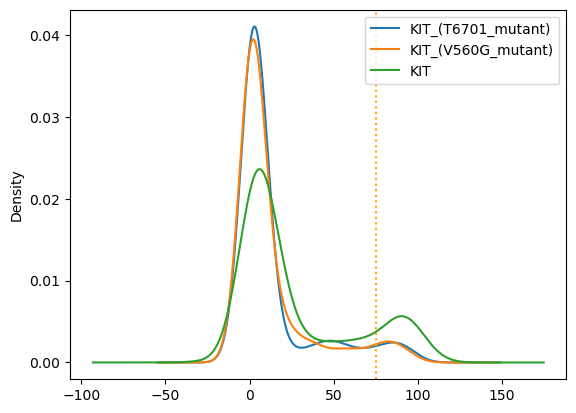

In [6]:
fig = data[data_cols].plot.kde()
plt.axvline(x=75, linestyle="dotted", color="orange")

### Perform data curation with `polaris.curation` module

In [7]:
# Define the threshold for classification conversion 
# we use the recommanded threshold 90% from the paper
# However, due to the number of active compounds and the above distribution
# We can lower the threshold to 75
th = 75
class_thresholds = {col: {"thresholds": [th]} for col in data_cols}

In [8]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=True,
    class_thresholds=class_thresholds
)
df_full = curator_with_stereo()

2023-10-30 01:47:45.805 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 12 outliers for data column KIT_(T6701_mutant) using zscore. Please revise the data and consider remove the outliers. 
2023-10-30 01:47:45.807 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 13 outliers for data column KIT_(V560G_mutant) using zscore. Please revise the data and consider remove the outliers. 


In [9]:
for col in data_cols:
    print(col)
    display(df_full.query(f'`OUTLIER_{col}` == True')[data_cols])

KIT_(T6701_mutant)


,KIT_(T6701_mutant),KIT_(V560G_mutant),KIT
22,90.35,84.840,95.86
66,93.35,83.480,106.47
75,88.28,78.570,95.99
124,88.36,82.170,90.58
155,89.86,93.400,95.27
200,98.13,92.510,97.26
221,94.85,80.430,98.71
296,88.50,71.610,100.33
310,95.26,78.270,99.35
313,90.79,88.205,101.04


KIT_(V560G_mutant)


,KIT_(T6701_mutant),KIT_(V560G_mutant),KIT
22,90.35,84.840,95.86
66,93.35,83.480,106.47
74,83.86,97.770,97.34
118,73.61,84.510,94.22
144,57.10,91.150,90.81
155,89.86,93.400,95.27
193,81.66,83.520,97.20
200,98.13,92.510,97.26
255,58.66,93.220,88.49
300,56.77,86.390,100.50


KIT


,KIT_(T6701_mutant),KIT_(V560G_mutant),KIT


The curation raised warning for potential outliers from the bioactivity readouts of 'KIT_(D816V_mutant)','KIT_(T6701_mutant)', 'KIT_(V560G_mutant)' mutants. The outlier labels are added in the curated output.  It's important to revise those data points and verify whether they are real outliers and should be removed from the dataset. 

We can also use other outlier detection methods by passing parameters to `outlier_params`. Please see more details in `polaris.curation.utils.outlier_detection`. 

[<Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>]

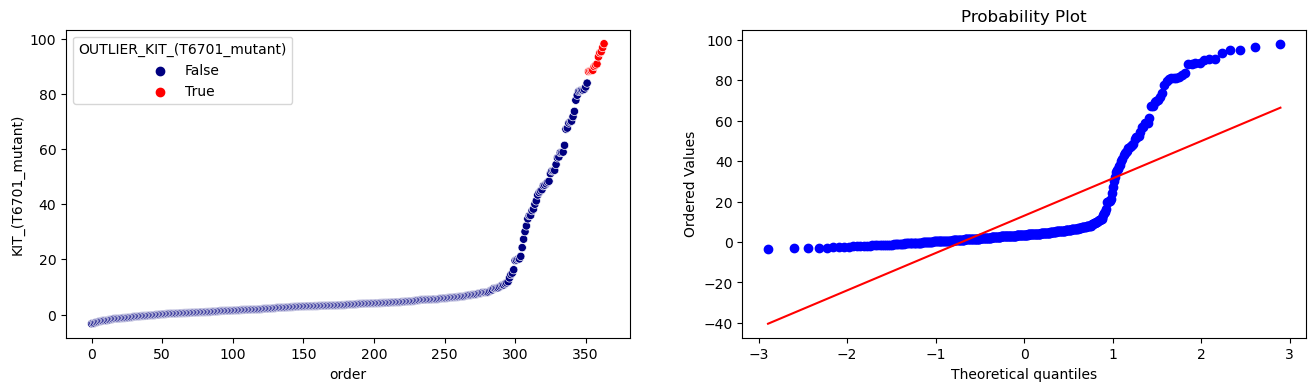

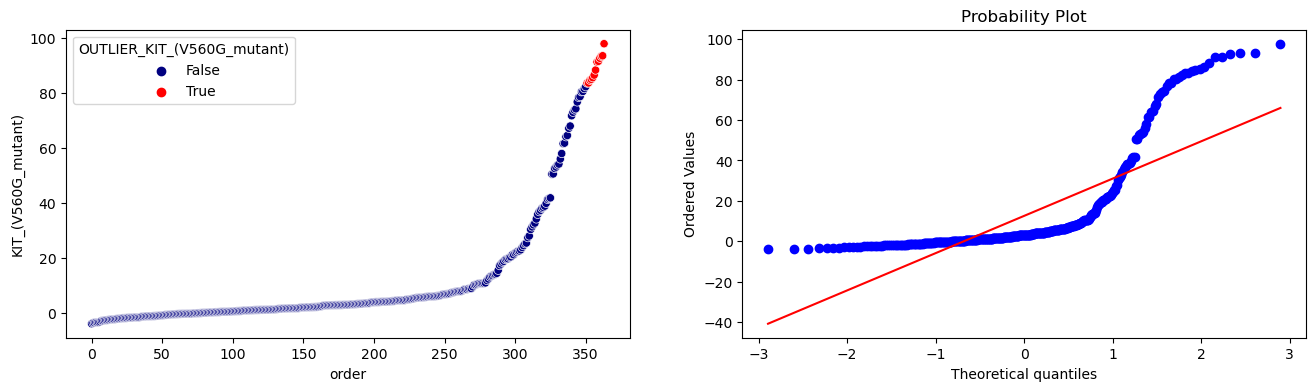

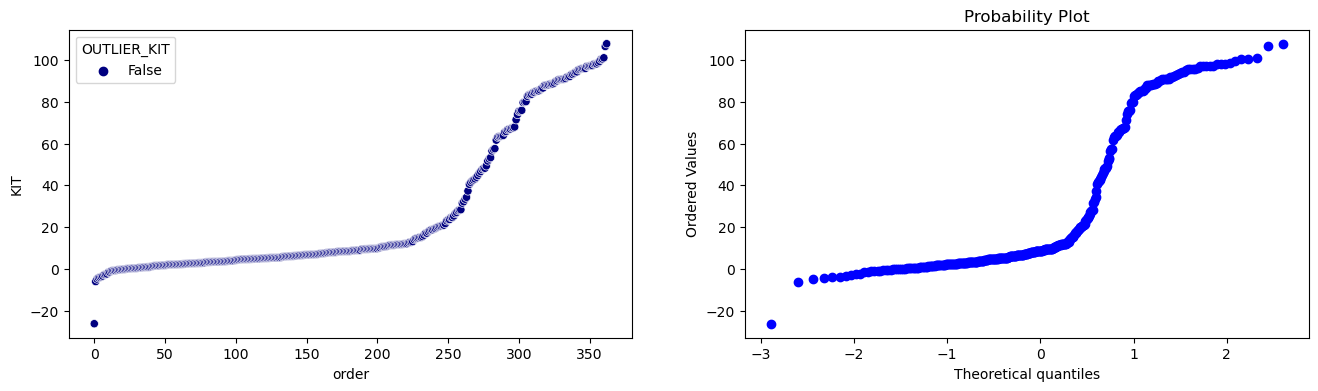

In [10]:
from polaris.curation.viz_utils import visulize_distribution
visulize_distribution(dataset=df_full, data_cols=data_cols)

The flagged outliers are likely false outliers as they are located on the terminals of the data distributions. 

### Check the compounds with undisered characters

In [11]:
from utils import basic_filter

In [12]:
processed_df = basic_filter(data = df_full, mol_col='smiles')

Filter by rules:   0%|          | 0/364 [00:00<?, ?it/s]

In [13]:
assert processed_df[processed_df.HasUndesiredEle].shape[0] == 0

There is no compounds which contains undiserable elements.

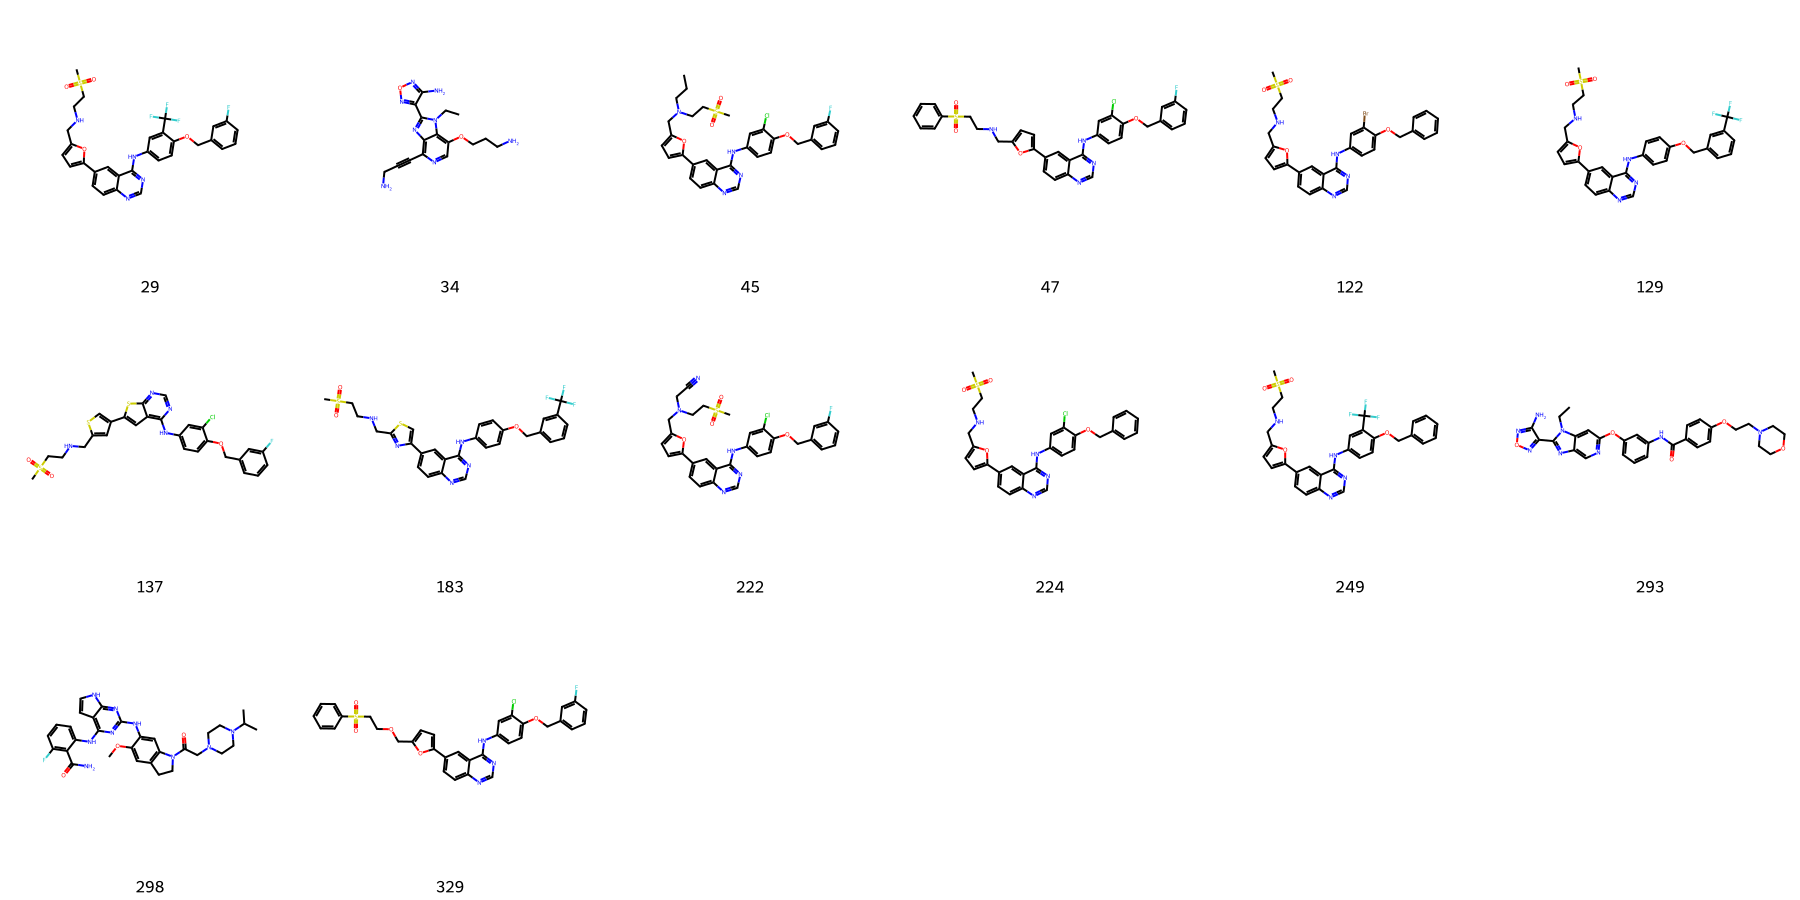

In [14]:
# visualize molecules which don't pass any of the nibr filters.
id_col = "molhash_id"
to_plot = processed_df[~processed_df.pass_any].reset_index()
legends=to_plot["index"].astype(str).tolist()
dm.to_image(to_plot['mol'].tolist(), 
            legends=legends, legendFraction=0.1,
            use_svg=True, n_cols=6)

NIBR filters are intended for molecule prioritization in the context of screening. \
Here we used to flag the molecules which are potentially undesired for the benchmark.\
From the above suggested molecules, there is no compound which contains striking unwanted substructure or extremely large groups. 

## Chemical space

In [15]:
mols = df_full.smiles.apply(dm.to_mol)
features = [dm.to_fp(mol) for mol in mols]

In [16]:
embedding = umap.UMAP().fit_transform(features)
df_full["UMAP_0"], df_full["UMAP_1"] = embedding[:, 0], embedding[:, 1]

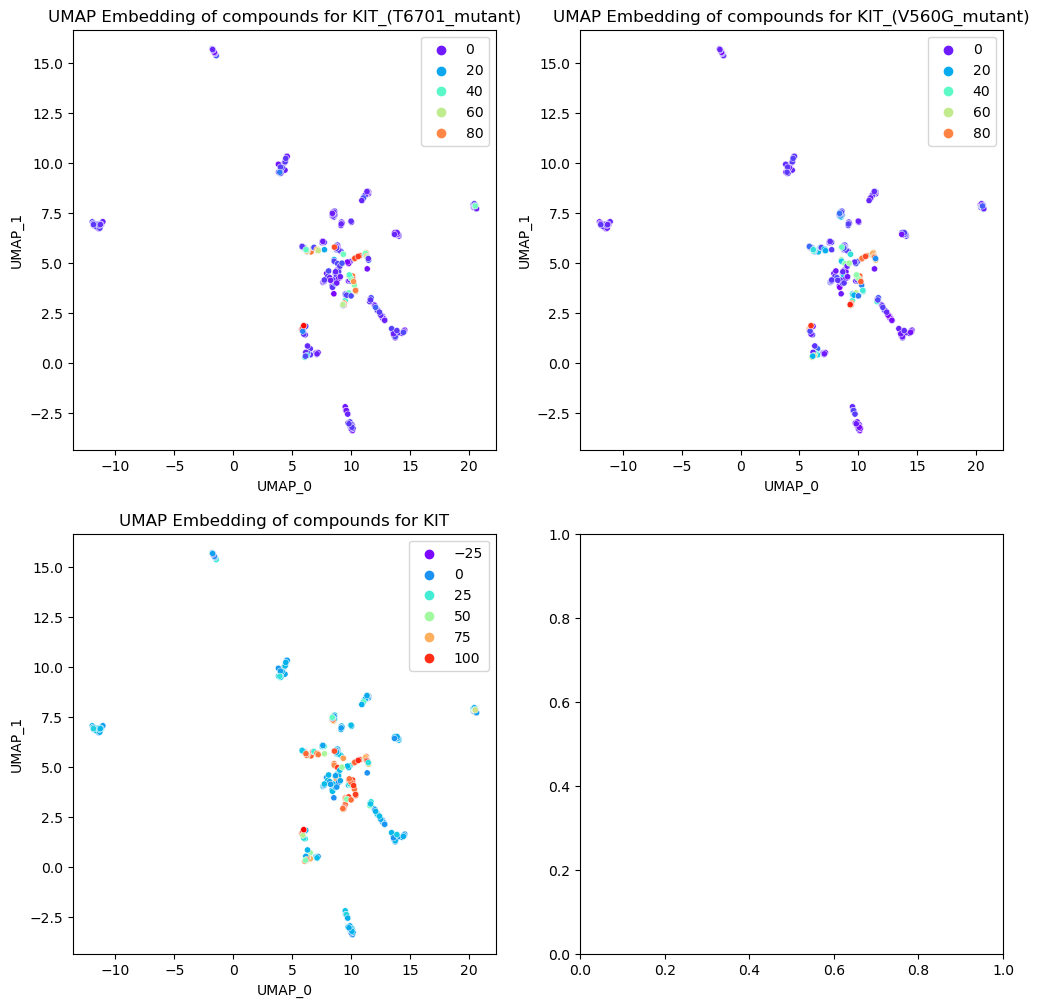

In [17]:
method = "UMAP"

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axes = axes.flatten()
for i, col in enumerate(data_cols):
    sns.scatterplot(
        data=df_full,
        x="UMAP_0",
        y="UMAP_1",
        palette="rainbow",
        hue=df_full[data_cols[i]].values,
        ax=axes[i],
        s=20,
    )
    axes[i].set_title(f"{method} Embedding of compounds for {col}")

With the above representation, the compounds spread in the chemical space. The goal are to 1) optimize the bioactivity % inhibition. 2) discovery of potential hits in new chemical space. Therefore a scaffold based split method is more relevant in this context. 

In [18]:
from polaris.curation._chemistry_curator import UNIQUE_ID
df_full.rename(columns={UNIQUE_ID: "UNIQUE_ID"}, inplace=True)
df_full.drop(columns=["UMAP_0", "UMAP_1"]).to_parquet(
    "gs://polaris-public/Data/kinases/KIT_mutants_curated.parquet", 
    index=False)